In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import cv2
import numpy as np
import os
import scipy.io as io
import matplotlib.pyplot as plt
import pickle

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers

import random
from tqdm import tqdm
from scipy.spatial.transform import Rotation

from custom_data_manager import AugmentationManager
from custom_data_manager import CustomDataCollector
from custom_data_manager import CustomDataLoader
from custom_data_manager import DataGeneratorBuilder
from model_manager import ModelManager

from utils import *

In [3]:
IMG_SIZE=96

In [4]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#     try:
#         tf.config.experimental.set_visible_devices([], 'GPU')
#     except RuntimeError as e:
#         # Visible devices must be set at program startup
#         print(e)

# tf.config.get_visible_devices()

## Prepare

In [5]:
#Takes long time
custom_ycb_path = "C:\\Users\\mati\\Desktop\\Moje\\dyplomowa\\datasets\\ycb_video_sicrod"

sub_dirs_to_load = ['0006', '0009', 
                    '0010','0011', '0012', '0018', '0024', 
                    '0030', '0037', '0038','0050', '0054','0056','0059','0077','0081',
                    '0083','0086','0088'
                   ]

#sub_dirs_to_load = ['0006', '0009','0010','0011','0012', '0018','0024','0030', 
#                    '0037', '0038','0050', '0054','0077','0081']



In [6]:
data_collector = CustomDataCollector(IMG_SIZE, sub_dirs_to_load, custom_ycb_path)
data_collector.collect()
frames_poses_dict = data_collector.frames_poses_dict

0006
0009
0010
0011
0012
0018
0024
0030
0037
0038
0050
0054
0056
0059
0077
0081
0083
0086
0088


In [16]:
train_types = ['0006', '0011',
                    '0010', '0018', '0030', 
                    '0037', '0038','0050', '0054','0056','0059','0077','0081',
                    '0083','0086','0088'
                   ]


val_types = ['0009','0012','0024']

In [153]:
k = 0
aug_pipeline = [
        #{"aug_type": "channel_shift", "parameters": []},
        #{"aug_type": "rotation", "parameters": [30]},
        #{"aug_type": "flip", "parameters": []},
        {"aug_type": "random_rectangles", "parameters": [50*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [25*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [13*k, 0.2, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.2, True]},
        #{"aug_type": "random_rectangles", "parameters": [2, 0.5, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.8, False]},
    
        #{"aug_type": "rotation", "parameters": [30]},
        #{"aug_type": "flip", "parameters": []},
        {"aug_type": "random_rectangles", "parameters": [50*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [25*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [12*k, 0.2, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.2, True]},
        #{"aug_type": "random_rectangles", "parameters": [2, 0.5, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.8, False]},
        #{"aug_type": "channel_shift", "parameters": []},
    ]

augmentator = AugmentationManager(aug_pipeline)

In [154]:
data_loader = CustomDataLoader(IMG_SIZE,augmentator)

## Generators

In [155]:
train_generator_builder = DataGeneratorBuilder(data_loader, frames_poses_dict, train_types, aug = True)
train_generator = train_generator_builder.generator
tf_train_generator = train_generator_builder.build_tf_generator()

val_generator_builder = DataGeneratorBuilder(data_loader, frames_poses_dict, val_types, aug = False)
val_generator = val_generator_builder.generator
tf_val_generator = val_generator_builder.build_tf_generator()

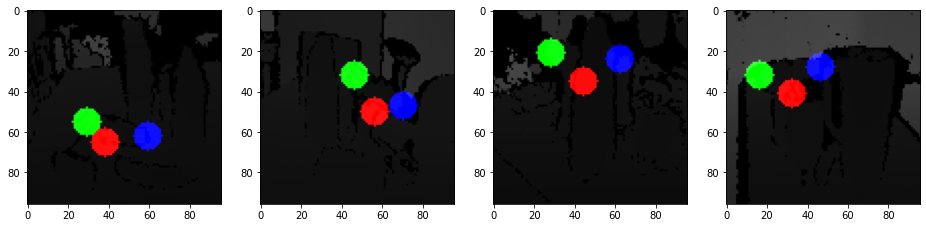

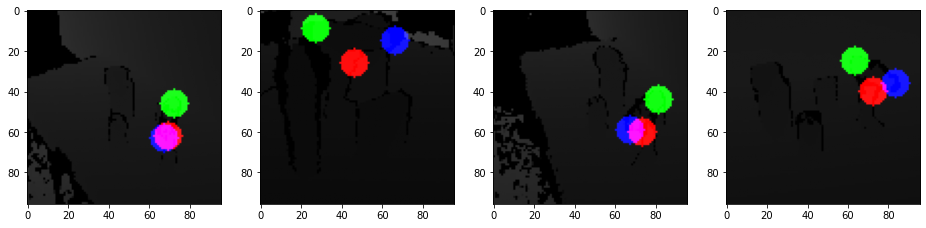

In [156]:
visualize_image_depth_data(train_generator)
visualize_image_depth_data(val_generator)

## Define Model

In [157]:
config = {}
model_manager = ModelManager(config)
model = model_manager.build_model_hourglass_2_blocks(IMG_SIZE,num_channels=6)

In [158]:
#model.summary()

In [159]:
def get_generator_images(generator, probes):
    images = []
    for _ in range(probes):
        frame, mask = next(generator)
        images.append(frame)
    return images

In [160]:
train_images = get_generator_images(train_generator, 32)
val_images = get_generator_images(val_generator, 32)

## Save Results

In [161]:
def save_plots(train_history, experiment_path):

    
    train_oks = [x[0] for x in train_history]
    val_oks = [x[1] for x in train_history]
    train_pdj = [x[2] for x in train_history]
    val_pdj = [x[3] for x in train_history]
    train_loss = [x[4] for x in train_history]
    val_loss = [x[5] for x in train_history]
    
    plt.plot(train_oks, label='train')
    plt.plot(val_oks, label='val')
    plt.legend(loc='best')
    plt.xlabel("Epochs")
    plt.ylabel("OKS metric %")
    plt.grid()
    plt.savefig(os.path.join(experiment_path,'books_oks.png'))
    plt.close()

    plt.plot(train_pdj, label='train')
    plt.plot(val_pdj, label='val')
    plt.legend(loc='best')
    plt.xlabel("Epochs")
    plt.ylabel("PDJ metric")
    plt.grid()
    plt.savefig(os.path.join(experiment_path,'books_pdj.png'))
    plt.close()
    
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(os.path.join(experiment_path,'books_loss.png'))
    plt.close()


        
def save_predicted_masks(model, train_images, val_images, experiment_train_images_path, experiment_val_images_path):
    train_images = np.array(train_images)
    val_images = np.array(val_images)
    train_predicted_masks = model.predict(train_images)
    val_predicted_masks = model.predict(val_images)
    
    fig = plt.figure(figsize=(16, 16))
    rows = 4
    columns = 4

    for i in range(16):
        img = train_images[i]
        mask = train_predicted_masks[1][i]
        fig.add_subplot(rows, columns, i+1)
        img_to_visualize = img[:,:,0:3]/3+mask[:,:,0:3]
        img_to_visualize = np.clip(img_to_visualize, 0, 1)
        plt.imshow(img_to_visualize)
    fig.savefig(experiment_train_images_path)
    plt.close() 
    
    fig = plt.figure(figsize=(16, 16))
    rows = 4
    columns = 4
    for i in range(16):
        img = val_images[i]
        mask = val_predicted_masks[1][i]
        fig.add_subplot(rows, columns, i+1)
        img_to_visualize = img[:,:,0:3]/3+mask[:,:,0:3]
        img_to_visualize = np.clip(img_to_visualize, 0, 1)
        plt.imshow(img_to_visualize)
    fig.savefig(experiment_val_images_path)
    plt.close() 

def save_results(train_history,model, train_images, val_images, epoch, experiment_name):

    
    results_path = "C:\\Users\\mati\\Desktop\\Moje\\dyplomowa\\repo\\Pose-estimation-hourglass\\rgbd_ycb\\results"
    experiment_path = os.path.join(results_path, experiment_name)
    experiment_train_images_path = os.path.join(results_path, experiment_name, "train_images")
    experiment_val_images_path = os.path.join(results_path, experiment_name, "val_images")
    if not os.path.exists(experiment_path):
        os.makedirs(experiment_path)
    if not os.path.exists(experiment_train_images_path):
        os.makedirs(experiment_train_images_path)
    if not os.path.exists(experiment_val_images_path):
        os.makedirs(experiment_val_images_path)
    
    experiment_train_images_path = os.path.join(experiment_train_images_path,f"epoch_{epoch}.png")
    experiment_val_images_path = os.path.join(experiment_val_images_path,f"epoch_{epoch}.png")
    save_plots(train_history, experiment_path)
    save_predicted_masks(model, 
                         train_images, 
                         val_images, 
                         experiment_train_images_path, 
                         experiment_val_images_path)
    


In [162]:
train_history = []

In [163]:
m_calc = MetricsCalculator()
#m_calc.calc_oks_metric(model,val_generator, 100)

class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch = epoch + 0
        train_oks = m_calc.calc_oks_metric(model,train_generator, 50)*100/IMG_SIZE
        val_oks = m_calc.calc_oks_metric(model,val_generator, 50)*100/IMG_SIZE
        train_pdj = m_calc.calc_pdj_metric(model,train_generator, 50)
        val_pdj = m_calc.calc_pdj_metric(model,val_generator, 50)
        train_loss = logs.get("head2_loss")
        val_loss = model.evaluate(tf_val_generator)[2]
        train_history.append((train_oks,val_oks,train_pdj,val_pdj,train_loss,val_loss))
        print()
        print("train_oks:", train_oks, "val_oks:",val_oks, "train_pdj:", train_pdj, "val_pdj:",val_pdj, "train_loss", train_loss)
        save_results(train_history,model, train_images, val_images, epoch, "rgbd_test_no_aug")
        return None

## Train

In [164]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0015)
model.compile(optimizer=opt, loss = "mse")

In [165]:
model.fit(tf_train_generator, 
            #validation_data = tf_val_generator,  
            epochs = 100, batch_size = 1,
           callbacks=[my_callback()]
           )

Epoch 1/100
38/38 [==============================] - 6s 130ms/step - loss: 0.0316 - head1_loss: 0.0159 - head2_loss: 0.0157

train_oks: 27.111142205839524 val_oks: 27.491593437631916 train_pdj: 0.022857142857142857 val_pdj: 0.031428571428571424 train_loss 0.020406555384397507
223/223 [==============================] - 73s 282ms/step - loss: 0.0398 - head1_loss: 0.0194 - head2_loss: 0.0204
Epoch 2/100
38/38 [==============================] - 4s 111ms/step - loss: 0.0305 - head1_loss: 0.0153 - head2_loss: 0.0152

train_oks: 22.44386448966532 val_oks: 22.197839734637686 train_pdj: 0.05142857142857142 val_pdj: 0.014285714285714284 train_loss 0.014350111596286297
223/223 [==============================] - 60s 271ms/step - loss: 0.0287 - head1_loss: 0.0143 - head2_loss: 0.0144
Epoch 3/100
38/38 [==============================] - 4s 107ms/step - loss: 0.0258 - head1_loss: 0.0129 - head2_loss: 0.0129

train_oks: 7.882113301891877 val_oks: 12.597113189259609 train_pdj: 0.6457142857142856 val_pd

223/223 [==============================] - 59s 265ms/step - loss: 0.0042 - head1_loss: 0.0022 - head2_loss: 0.0020
Epoch 18/100
38/38 [==============================] - 4s 90ms/step - loss: 0.0231 - head1_loss: 0.0115 - head2_loss: 0.0116

train_oks: 0.5861111674350395 val_oks: 10.252057069577962 train_pdj: 0.9685714285714286 val_pdj: 0.47428571428571425 train_loss 0.0019558186177164316
223/223 [==============================] - 59s 265ms/step - loss: 0.0042 - head1_loss: 0.0022 - head2_loss: 0.0020
Epoch 19/100
38/38 [==============================] - 3s 89ms/step - loss: 0.0241 - head1_loss: 0.0119 - head2_loss: 0.0122

train_oks: 0.6298750354156079 val_oks: 11.901131098078432 train_pdj: 0.9885714285714287 val_pdj: 0.4257142857142856 train_loss 0.0019055036827921867
223/223 [==============================] - 59s 264ms/step - loss: 0.0041 - head1_loss: 0.0021 - head2_loss: 0.0019
Epoch 20/100
38/38 [==============================] - 3s 89ms/step - loss: 0.0227 - head1_loss: 0.0113 - h

223/223 [==============================] - 60s 268ms/step - loss: 0.0034 - head1_loss: 0.0018 - head2_loss: 0.0016
Epoch 35/100
38/38 [==============================] - 4s 91ms/step - loss: 0.0239 - head1_loss: 0.0119 - head2_loss: 0.0120

train_oks: 0.5283300867536389 val_oks: 11.661938545931868 train_pdj: 0.9857142857142859 val_pdj: 0.48285714285714276 train_loss 0.0015776170184835792
223/223 [==============================] - 60s 268ms/step - loss: 0.0034 - head1_loss: 0.0018 - head2_loss: 0.0016
Epoch 36/100
38/38 [==============================] - 4s 93ms/step - loss: 0.0254 - head1_loss: 0.0125 - head2_loss: 0.0129

train_oks: 0.48138245155619114 val_oks: 11.828974548700335 train_pdj: 0.9914285714285714 val_pdj: 0.44857142857142857 train_loss 0.0015681985532864928
223/223 [==============================] - 60s 270ms/step - loss: 0.0034 - head1_loss: 0.0018 - head2_loss: 0.0016
Epoch 37/100
38/38 [==============================] - 4s 95ms/step - loss: 0.0239 - head1_loss: 0.0118 -

38/38 [==============================] - 5s 137ms/step - loss: 0.0241 - head1_loss: 0.0120 - head2_loss: 0.0122

train_oks: 0.3872690913468522 val_oks: 12.888592166340269 train_pdj: 0.9942857142857143 val_pdj: 0.48 train_loss 0.0013914851006120443
223/223 [==============================] - 63s 283ms/step - loss: 0.0031 - head1_loss: 0.0017 - head2_loss: 0.0014
Epoch 52/100
38/38 [==============================] - 5s 134ms/step - loss: 0.0242 - head1_loss: 0.0120 - head2_loss: 0.0122

train_oks: 0.5145091771438939 val_oks: 13.643431663123039 train_pdj: 0.9857142857142859 val_pdj: 0.4799999999999999 train_loss 0.0013759270077571273
223/223 [==============================] - 63s 283ms/step - loss: 0.0030 - head1_loss: 0.0017 - head2_loss: 0.0014
Epoch 53/100
38/38 [==============================] - 5s 136ms/step - loss: 0.0240 - head1_loss: 0.0119 - head2_loss: 0.0121

train_oks: 0.4199682478425715 val_oks: 10.060524807661874 train_pdj: 0.9885714285714287 val_pdj: 0.4514285714285714 train

223/223 [==============================] - 65s 293ms/step - loss: 0.0028 - head1_loss: 0.0016 - head2_loss: 0.0012
Epoch 68/100
38/38 [==============================] - 6s 162ms/step - loss: 0.0255 - head1_loss: 0.0126 - head2_loss: 0.0129

train_oks: 0.3696151193732074 val_oks: 14.306107695227004 train_pdj: 0.9742857142857143 val_pdj: 0.46285714285714286 train_loss 0.001179079874418676
223/223 [==============================] - 66s 295ms/step - loss: 0.0028 - head1_loss: 0.0016 - head2_loss: 0.0012
Epoch 69/100
38/38 [==============================] - 6s 158ms/step - loss: 0.0241 - head1_loss: 0.0120 - head2_loss: 0.0122

train_oks: 0.3119759946692154 val_oks: 9.862248877801806 train_pdj: 0.9885714285714287 val_pdj: 0.5057142857142857 train_loss 0.0011614179238677025
223/223 [==============================] - 66s 294ms/step - loss: 0.0027 - head1_loss: 0.0016 - head2_loss: 0.0012
Epoch 70/100
38/38 [==============================] - 6s 158ms/step - loss: 0.0248 - head1_loss: 0.0123 - 

38/38 [==============================] - 5s 128ms/step - loss: 0.0243 - head1_loss: 0.0121 - head2_loss: 0.0122

train_oks: 0.3422806537933441 val_oks: 13.30460002807208 train_pdj: 0.9857142857142859 val_pdj: 0.43999999999999995 train_loss 0.000993722933344543
223/223 [==============================] - 63s 282ms/step - loss: 0.0025 - head1_loss: 0.0015 - head2_loss: 9.9372e-04
Epoch 85/100
38/38 [==============================] - 5s 126ms/step - loss: 0.0246 - head1_loss: 0.0122 - head2_loss: 0.0124

train_oks: 0.25491629450013475 val_oks: 12.160112321173855 train_pdj: 0.9657142857142857 val_pdj: 0.48285714285714276 train_loss 0.000989733380265534
223/223 [==============================] - 62s 280ms/step - loss: 0.0025 - head1_loss: 0.0015 - head2_loss: 9.8973e-04
Epoch 86/100
38/38 [==============================] - 5s 132ms/step - loss: 0.0245 - head1_loss: 0.0121 - head2_loss: 0.0124

train_oks: 0.1920300785030331 val_oks: 14.586299148169187 train_pdj: 0.98 val_pdj: 0.42571428571428

223/223 [==============================] - 63s 283ms/step - loss: 0.0024 - head1_loss: 0.0015 - head2_loss: 8.6349e-04


In [94]:
k = 2
aug_pipeline = [
        {"aug_type": "channel_shift", "parameters": []},
        {"aug_type": "rotation", "parameters": [60]},
        {"aug_type": "flip", "parameters": []},
        {"aug_type": "random_rectangles", "parameters": [50*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [25*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [13*k, 0.2, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.2, True]},
        #{"aug_type": "random_rectangles", "parameters": [2, 0.5, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.8, False]},
    
        {"aug_type": "rotation", "parameters": [60]},
        #{"aug_type": "flip", "parameters": []},
        {"aug_type": "random_rectangles", "parameters": [50*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [25*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [12*k, 0.2, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.2, True]},
        #{"aug_type": "random_rectangles", "parameters": [2, 0.5, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.8, False]},
        {"aug_type": "channel_shift", "parameters": []},
    ]

augmentator = AugmentationManager(aug_pipeline)

In [95]:
data_loader = CustomDataLoader(IMG_SIZE,augmentator)

In [96]:
# gENERATORS

In [97]:
train_generator_builder = DataGeneratorBuilder(data_loader, frames_poses_dict, train_types, aug = True)
train_generator = train_generator_builder.generator
tf_train_generator = train_generator_builder.build_tf_generator()

val_generator_builder = DataGeneratorBuilder(data_loader, frames_poses_dict, val_types, aug = False)
val_generator = val_generator_builder.generator
tf_val_generator = val_generator_builder.build_tf_generator()

In [98]:
config = {}
model_manager = ModelManager(config)
model = model_manager.build_model_hourglass_2_blocks(IMG_SIZE,num_channels=6)

In [99]:
train_images = get_generator_images(train_generator, 32)
val_images = get_generator_images(val_generator, 32)

In [100]:
train_history = []

In [101]:
m_calc = MetricsCalculator()
#m_calc.calc_oks_metric(model,val_generator, 100)

class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch = epoch + 0
        train_oks = m_calc.calc_oks_metric(model,train_generator, 50)*100/IMG_SIZE
        val_oks = m_calc.calc_oks_metric(model,val_generator, 50)*100/IMG_SIZE
        train_pdj = m_calc.calc_pdj_metric(model,train_generator, 50)
        val_pdj = m_calc.calc_pdj_metric(model,val_generator, 50)
        train_loss = logs.get("head2_loss")
        val_loss = model.evaluate(tf_val_generator)[2]
        train_history.append((train_oks,val_oks,train_pdj,val_pdj,train_loss,val_loss))
        print()
        print("train_oks:", train_oks, "val_oks:",val_oks, "train_pdj:", train_pdj, "val_pdj:",val_pdj, "train_loss", train_loss)
        save_results(train_history,model, train_images, val_images, epoch, "rgbd_test_aug_v3")
        return None

In [102]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0015)
model.compile(optimizer=opt, loss = "mse")

In [103]:
model.fit(tf_train_generator, 
            #validation_data = tf_val_generator,  
            epochs = 100, batch_size = 1,
           callbacks=[my_callback()]
           )

Epoch 1/100
38/38 [==============================] - 4s 86ms/step - loss: 0.0314 - head1_loss: 0.0158 - head2_loss: 0.0156

train_oks: 27.45472689321042 val_oks: 27.208578336738565 train_pdj: 0.02571428571428571 val_pdj: 0.02 train_loss 0.018523383885622025
223/223 [==============================] - 63s 259ms/step - loss: 0.0388 - head1_loss: 0.0202 - head2_loss: 0.0185
Epoch 2/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0316 - head1_loss: 0.0155 - head2_loss: 0.0161

train_oks: 27.629196672997097 val_oks: 26.706063017605477 train_pdj: 0.022857142857142857 val_pdj: 0.01714285714285714 train_loss 0.013841168954968452
223/223 [==============================] - 56s 253ms/step - loss: 0.0277 - head1_loss: 0.0139 - head2_loss: 0.0138
Epoch 3/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0315 - head1_loss: 0.0153 - head2_loss: 0.0163

train_oks: 23.667146733747032 val_oks: 22.90832524983955 train_pdj: 0.0657142857142857 val_pdj: 0.045714285714285

Epoch 18/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0261 - head1_loss: 0.0128 - head2_loss: 0.0133

train_oks: 2.7544338899351892 val_oks: 9.280601279727092 train_pdj: 0.9057142857142857 val_pdj: 0.3685714285714285 train_loss 0.005317493341863155
223/223 [==============================] - 57s 253ms/step - loss: 0.0132 - head1_loss: 0.0079 - head2_loss: 0.0053
Epoch 19/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0256 - head1_loss: 0.0128 - head2_loss: 0.0128

train_oks: 2.563628346794623 val_oks: 11.650638217478722 train_pdj: 0.9342857142857143 val_pdj: 0.3914285714285714 train_loss 0.005066015291959047
223/223 [==============================] - 57s 254ms/step - loss: 0.0126 - head1_loss: 0.0075 - head2_loss: 0.0051
Epoch 20/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0256 - head1_loss: 0.0126 - head2_loss: 0.0130

train_oks: 2.077982020104084 val_oks: 9.489913081618523 train_pdj: 0.8885714285714286 val_pdj: 0.36 t

Epoch 35/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0254 - head1_loss: 0.0126 - head2_loss: 0.0127

train_oks: 1.307883392616268 val_oks: 8.790193989183908 train_pdj: 0.9657142857142859 val_pdj: 0.3657142857142857 train_loss 0.00318340677767992
223/223 [==============================] - 56s 251ms/step - loss: 0.0075 - head1_loss: 0.0044 - head2_loss: 0.0032
Epoch 36/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0253 - head1_loss: 0.0125 - head2_loss: 0.0128

train_oks: 1.4567962377874546 val_oks: 7.712582433914144 train_pdj: 0.96 val_pdj: 0.46857142857142864 train_loss 0.0031631914898753166
223/223 [==============================] - 58s 260ms/step - loss: 0.0075 - head1_loss: 0.0043 - head2_loss: 0.0032
Epoch 37/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0250 - head1_loss: 0.0124 - head2_loss: 0.0126

train_oks: 1.4608603465633843 val_oks: 7.291016595593406 train_pdj: 0.9542857142857143 val_pdj: 0.46 train_loss 0.0

Epoch 52/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0238 - head1_loss: 0.0120 - head2_loss: 0.0117

train_oks: 1.422815723234726 val_oks: 7.7798921396513725 train_pdj: 0.9657142857142857 val_pdj: 0.4085714285714286 train_loss 0.002671492286026478
223/223 [==============================] - 57s 253ms/step - loss: 0.0063 - head1_loss: 0.0036 - head2_loss: 0.0027
Epoch 53/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0243 - head1_loss: 0.0122 - head2_loss: 0.0120

train_oks: 1.1866149121636116 val_oks: 6.505888332187072 train_pdj: 0.9514285714285714 val_pdj: 0.4171428571428571 train_loss 0.0026643634773790836
223/223 [==============================] - 56s 253ms/step - loss: 0.0063 - head1_loss: 0.0036 - head2_loss: 0.0027
Epoch 54/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0242 - head1_loss: 0.0124 - head2_loss: 0.0118

train_oks: 1.0943154471336844 val_oks: 7.9886879441836705 train_pdj: 0.9714285714285714 val_pdj: 0.4

223/223 [==============================] - 58s 257ms/step - loss: 0.0057 - head1_loss: 0.0033 - head2_loss: 0.0024
Epoch 69/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0235 - head1_loss: 0.0120 - head2_loss: 0.0115

train_oks: 1.070818304813226 val_oks: 7.182803836235638 train_pdj: 0.9742857142857143 val_pdj: 0.46857142857142847 train_loss 0.0024247949477285147
223/223 [==============================] - 57s 256ms/step - loss: 0.0057 - head1_loss: 0.0032 - head2_loss: 0.0024
Epoch 70/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0242 - head1_loss: 0.0122 - head2_loss: 0.0120

train_oks: 1.3048500086005193 val_oks: 8.635525800599803 train_pdj: 0.9742857142857143 val_pdj: 0.3999999999999999 train_loss 0.0024205916561186314
223/223 [==============================] - 57s 257ms/step - loss: 0.0057 - head1_loss: 0.0033 - head2_loss: 0.0024
Epoch 71/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0244 - head1_loss: 0.0123 - head

223/223 [==============================] - 58s 257ms/step - loss: 0.0053 - head1_loss: 0.0030 - head2_loss: 0.0022
Epoch 86/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0247 - head1_loss: 0.0125 - head2_loss: 0.0123

train_oks: 1.102140617994576 val_oks: 8.21235376073693 train_pdj: 0.9771428571428572 val_pdj: 0.4485714285714286 train_loss 0.002248027129098773
223/223 [==============================] - 58s 258ms/step - loss: 0.0053 - head1_loss: 0.0030 - head2_loss: 0.0022
Epoch 87/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0244 - head1_loss: 0.0123 - head2_loss: 0.0121

train_oks: 1.1714123917725758 val_oks: 9.831129904037981 train_pdj: 0.9714285714285714 val_pdj: 0.5085714285714286 train_loss 0.0022395001724362373
223/223 [==============================] - 58s 259ms/step - loss: 0.0052 - head1_loss: 0.0030 - head2_loss: 0.0022
Epoch 88/100
38/38 [==============================] - 3s 87ms/step - loss: 0.0244 - head1_loss: 0.0123 - head2_l

In [104]:
k = 3
aug_pipeline = [
        {"aug_type": "channel_shift", "parameters": []},
        {"aug_type": "rotation", "parameters": [60]},
        {"aug_type": "flip", "parameters": []},
        {"aug_type": "random_rectangles", "parameters": [50*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [25*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [13*k, 0.2, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.2, True]},
        #{"aug_type": "random_rectangles", "parameters": [2, 0.5, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.8, False]},
    
        {"aug_type": "rotation", "parameters": [60]},
        #{"aug_type": "flip", "parameters": []},
        {"aug_type": "random_rectangles", "parameters": [50*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [25*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [12*k, 0.2, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.2, True]},
        #{"aug_type": "random_rectangles", "parameters": [2, 0.5, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.8, False]},
        {"aug_type": "channel_shift", "parameters": []},
    ]

augmentator = AugmentationManager(aug_pipeline)

In [105]:
data_loader = CustomDataLoader(IMG_SIZE,augmentator)

In [106]:
# gENERATORS

In [107]:
train_generator_builder = DataGeneratorBuilder(data_loader, frames_poses_dict, train_types, aug = True)
train_generator = train_generator_builder.generator
tf_train_generator = train_generator_builder.build_tf_generator()

val_generator_builder = DataGeneratorBuilder(data_loader, frames_poses_dict, val_types, aug = False)
val_generator = val_generator_builder.generator
tf_val_generator = val_generator_builder.build_tf_generator()

In [108]:
config = {}
model_manager = ModelManager(config)
model = model_manager.build_model_hourglass_2_blocks(IMG_SIZE,num_channels=6)

In [109]:
train_images = get_generator_images(train_generator, 32)
val_images = get_generator_images(val_generator, 32)

In [110]:
train_history = []

In [111]:
m_calc = MetricsCalculator()
#m_calc.calc_oks_metric(model,val_generator, 100)

class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch = epoch + 0
        train_oks = m_calc.calc_oks_metric(model,train_generator, 50)*100/IMG_SIZE
        val_oks = m_calc.calc_oks_metric(model,val_generator, 50)*100/IMG_SIZE
        train_pdj = m_calc.calc_pdj_metric(model,train_generator, 50)
        val_pdj = m_calc.calc_pdj_metric(model,val_generator, 50)
        train_loss = logs.get("head2_loss")
        val_loss = model.evaluate(tf_val_generator)[2]
        train_history.append((train_oks,val_oks,train_pdj,val_pdj,train_loss,val_loss))
        print()
        print("train_oks:", train_oks, "val_oks:",val_oks, "train_pdj:", train_pdj, "val_pdj:",val_pdj, "train_loss", train_loss)
        save_results(train_history,model, train_images, val_images, epoch, "rgbd_test_aug_v3")
        return None

In [112]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0015)
model.compile(optimizer=opt, loss = "mse")

In [113]:
model.fit(tf_train_generator, 
            #validation_data = tf_val_generator,  
            epochs = 100, batch_size = 1,
           callbacks=[my_callback()]
           )

Epoch 1/100
38/38 [==============================] - 4s 86ms/step - loss: 0.0314 - head1_loss: 0.0157 - head2_loss: 0.0157

train_oks: 27.034856363579973 val_oks: 28.48540760960833 train_pdj: 0.014285714285714284 val_pdj: 0.01714285714285714 train_loss 0.018293004482984543
223/223 [==============================] - 73s 257ms/step - loss: 0.0366 - head1_loss: 0.0183 - head2_loss: 0.0183
Epoch 2/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0308 - head1_loss: 0.0154 - head2_loss: 0.0153

train_oks: 25.30307399089129 val_oks: 21.899724671405195 train_pdj: 0.014285714285714284 val_pdj: 0.022857142857142857 train_loss 0.013757552951574326
223/223 [==============================] - 56s 249ms/step - loss: 0.0276 - head1_loss: 0.0138 - head2_loss: 0.0138
Epoch 3/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0331 - head1_loss: 0.0173 - head2_loss: 0.0158

train_oks: 24.83288547010549 val_oks: 21.51464729606838 train_pdj: 0.04 val_pdj: 0.02857142857142

Epoch 18/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0264 - head1_loss: 0.0130 - head2_loss: 0.0134

train_oks: 3.2463444060895585 val_oks: 8.513741276287405 train_pdj: 0.8714285714285712 val_pdj: 0.42857142857142855 train_loss 0.005214644130319357
223/223 [==============================] - 56s 251ms/step - loss: 0.0117 - head1_loss: 0.0065 - head2_loss: 0.0052
Epoch 19/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0262 - head1_loss: 0.0130 - head2_loss: 0.0132

train_oks: 2.6408760801609166 val_oks: 13.415748301365577 train_pdj: 0.9257142857142857 val_pdj: 0.3714285714285714 train_loss 0.004974693525582552
223/223 [==============================] - 56s 251ms/step - loss: 0.0112 - head1_loss: 0.0062 - head2_loss: 0.0050
Epoch 20/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0258 - head1_loss: 0.0131 - head2_loss: 0.0126

train_oks: 4.6426669557177505 val_oks: 10.159061350942007 train_pdj: 0.9028571428571428 val_pdj: 0.

Epoch 35/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0252 - head1_loss: 0.0127 - head2_loss: 0.0125

train_oks: 1.6205390577831167 val_oks: 10.073209789781316 train_pdj: 0.9742857142857143 val_pdj: 0.4571428571428571 train_loss 0.003272845409810543
223/223 [==============================] - 57s 253ms/step - loss: 0.0076 - head1_loss: 0.0043 - head2_loss: 0.0033
Epoch 36/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0263 - head1_loss: 0.0132 - head2_loss: 0.0131

train_oks: 1.497895362596129 val_oks: 9.801824436214414 train_pdj: 0.9457142857142858 val_pdj: 0.37142857142857133 train_loss 0.003176122670993209
223/223 [==============================] - 57s 253ms/step - loss: 0.0073 - head1_loss: 0.0042 - head2_loss: 0.0032
Epoch 37/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0247 - head1_loss: 0.0128 - head2_loss: 0.0119

train_oks: 1.380605438289933 val_oks: 9.266298356900693 train_pdj: 0.9628571428571427 val_pdj: 0.434

223/223 [==============================] - 58s 260ms/step - loss: 0.0063 - head1_loss: 0.0036 - head2_loss: 0.0027
Epoch 52/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0246 - head1_loss: 0.0125 - head2_loss: 0.0121

train_oks: 1.371435059214545 val_oks: 9.970655936067741 train_pdj: 0.9771428571428572 val_pdj: 0.5457142857142856 train_loss 0.002677019452676177
223/223 [==============================] - 61s 273ms/step - loss: 0.0063 - head1_loss: 0.0036 - head2_loss: 0.0027
Epoch 53/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0249 - head1_loss: 0.0128 - head2_loss: 0.0121

train_oks: 1.2900397838666844 val_oks: 8.000745080806485 train_pdj: 0.9514285714285714 val_pdj: 0.41142857142857137 train_loss 0.0027353435289114714
223/223 [==============================] - 59s 262ms/step - loss: 0.0064 - head1_loss: 0.0036 - head2_loss: 0.0027
Epoch 54/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0278 - head1_loss: 0.0138 - head2

223/223 [==============================] - 59s 262ms/step - loss: 0.0057 - head1_loss: 0.0033 - head2_loss: 0.0024
Epoch 69/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0242 - head1_loss: 0.0126 - head2_loss: 0.0116

train_oks: 1.2078194711281975 val_oks: 8.964864654578596 train_pdj: 0.9714285714285715 val_pdj: 0.4571428571428571 train_loss 0.002447142032906413
223/223 [==============================] - 59s 265ms/step - loss: 0.0057 - head1_loss: 0.0033 - head2_loss: 0.0024
Epoch 70/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0252 - head1_loss: 0.0130 - head2_loss: 0.0122

train_oks: 1.139277180818781 val_oks: 7.263466289917207 train_pdj: 0.9914285714285714 val_pdj: 0.4799999999999999 train_loss 0.002428343752399087
223/223 [==============================] - 58s 261ms/step - loss: 0.0057 - head1_loss: 0.0033 - head2_loss: 0.0024
Epoch 71/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0248 - head1_loss: 0.0127 - head2_l

223/223 [==============================] - 61s 273ms/step - loss: 0.0053 - head1_loss: 0.0031 - head2_loss: 0.0023
Epoch 86/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0248 - head1_loss: 0.0128 - head2_loss: 0.0120

train_oks: 1.0656179265493557 val_oks: 10.186901559583385 train_pdj: 0.9799999999999999 val_pdj: 0.39428571428571424 train_loss 0.002274965401738882
223/223 [==============================] - 59s 266ms/step - loss: 0.0053 - head1_loss: 0.0031 - head2_loss: 0.0023
Epoch 87/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0244 - head1_loss: 0.0126 - head2_loss: 0.0119

train_oks: 1.2299323402880284 val_oks: 7.325143730907186 train_pdj: 0.9657142857142857 val_pdj: 0.5142857142857143 train_loss 0.0022670694161206484
223/223 [==============================] - 60s 268ms/step - loss: 0.0053 - head1_loss: 0.0031 - head2_loss: 0.0023
Epoch 88/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0243 - head1_loss: 0.0124 - hea